# Import

In [1]:
import random
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import numpy as np
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fp = fm.FontProperties(fname='/home/studio-lab-user/Dacon/tools/NanumFont/NanumGothic.ttf', size=10)
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device :',device)

device : cpu


<br></br>

# Setting

<br>

## Hyperparameter Setting

In [3]:
CFG = {
    'EPOCHS':128,#1024,
    'PATIENCE':30,
    'LEARNING_RATE':0.05,
    'BATCH_SIZE':16,
    'SEED':42,
}

<br>

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# seed_everything(CFG['SEED']) # Seed 고정

<br></br>

# Data Pre-processing

In [69]:
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

class Preprocess:
    def __init__(self, input_paths, label_paths, test_paths):
        self.input_paths = input_paths
        self.label_paths = label_paths
        self.test_paths  = test_paths
        
        self.input, self.label, self.test = None, None, None
        
        self.X_train, self.X_valid = None, None
        self.y_train, self.y_valid = None, None
        self.X, self.y = None, None

        input_fn = []
        label_fn = []
        for input_path, label_path in zip(self.input_paths, self.label_paths):
            case_num = input_path.replace('./data/train_input/CASE_','').replace('.csv','')
            
            input_df = pd.read_csv(input_path)
            label_df = pd.read_csv(label_path)

            input_df = input_df.fillna(0)

            input_df['case_num'] = case_num
            label_df['case_num'] = case_num
            
            input_fn.append(input_df)
            label_fn.append(label_df)
        
        test_fn = []
        for test_path in self.test_paths:
            test_df = pd.read_csv(test_path)
            case_num = test_path.replace('./data/test_input/TEST_','').replace('.csv','')
            
            test_df['case_num'] = case_num
            
            test_fn.append(test_df)
            
        self.input = pd.concat(input_fn,axis=0).sort_values(['case_num','DAT','obs_time'])
        self.label = pd.concat(label_fn,axis=0)
        self.test  = pd.concat(test_fn ,axis=0)
        
        self.input.obs_time = list(np.arange(0,24))*int(self.input.shape[0]/24)
        self.test .obs_time = list(np.arange(0,24))*int(self.test .shape[0]/24)
        
    def _data_return(self):
        return self.input,self.label,self.test
        
    def _target_log(self):
        self.label['predicted_weight_g'] = np.log(self.label['predicted_weight_g'])
        
    # https://dacon.io/competitions/official/236033/talkboard/407304?page=1&dtype=recent
    def _scale_dataset(self,outlier):
        
        minmax_info = {
            '내부온도관측치':[4,40],
            '내부습도관측치':[0,100],
            'co2관측치':[0,1200],
            'ec관측치':[0,8],
            '시간당분무량':[0,3000],
            '일간누적분무량':[0,72000],
            '시간당백색광량':[0,120000],
            '일간누적백색광량':[0,2880000],
            '시간당적색광량':[0,120000],
            '일간누적적색광량':[0,2880000],
            '시간당청색광량':[0,120000],
            '일간누적청색광량':[0,2880000],
            '시간당총광량':[0,120000],
            '일간누적총광량':[0,2880000],
        }
            
        scale_feature = [feature for feature,(min_info,max_info) in minmax_info.items()]
        
        # for train dataset
        for col in scale_feature:
            min_info,max_info = minmax_info[col]
            self.input[col] = (self.input[col]-min_info) / (max_info-min_info)
            
            if outlier=='keep':
                # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                # -> 삭제하게되면 24시간의 term이 깨짐
                self.input[col][self.input[col]<0] = 0
                self.input[col][self.input[col]>1] = 1
            elif outlier=='drop':
                self.input[col][(self.input[col]<0)] = np.nan
                self.input[col][(self.input[col]>1)] = np.nan
            
        # for test dataset
        for col in scale_feature:
            min_info,max_info = minmax_info[col]
            self.test[col] = (self.test[col]-min_info) / (max_info-min_info)
            
            if outlier=='keep':
                # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                # -> 삭제하게되면 24시간의 term이 깨짐
                self.test[col][self.test[col]<0] = 0
                self.test[col][self.test[col]>1] = 1
            elif outlier=='drop':
                self.test[col][(self.test[col]<0)] = np.nan
                self.test[col][(self.test[col]>1)] = np.nan
        
    # def _data_pivot(self):

    #     # obs_time이 이상하게 들어간 것들이 있어서, 0~23의 값으로 변경
    #     self.input['obs_time'] = list(np.arange(0,24))*28*28
    #     self.test ['obs_time'] = list(np.arange(0,24))*28*5

    #     # copy for save
    #     new_input_df = self.input[['case_num','DAT']].drop_duplicates()
    #     new_test_df  = self.test [['case_num','DAT']].drop_duplicates()

    #     # 컬럼별로 pivot 적용
    #     pivot_columns = [col for col in self.input.columns if col not in ['DAT','obs_time','case_num']]
    #     for col in pivot_columns:

    #         # for input data
    #         i_df = pd.pivot_table(self.input,index=['case_num','DAT'],columns='obs_time',values=col,aggfunc=np.mean)\
    #             .add_prefix(f'{col}_t')\
    #             .reset_index()\
    #             .rename_axis(None, axis=1)

    #         # for test_data
    #         t_df = pd.pivot_table(self.test,index=['case_num','DAT'],columns='obs_time',values=col,aggfunc=np.mean)\
    #             .add_prefix(f'{col}_t')\
    #             .reset_index()\
    #             .rename_axis(None, axis=1)

    #         # merge
    #         new_input_df = pd.merge(new_input_df,i_df,how='left',on=['case_num','DAT'])
    #         new_test_df  = pd.merge(new_test_df ,t_df,how='left',on=['case_num','DAT'])

    #     # pivot data -> input / test data
    #     self.input = new_input_df.copy()
    #     self.test  = new_test_df .copy()

    #     unique_info = self.input.apply(lambda x: x.nunique())
    #     unique_cols = unique_info[unique_info==1].index.tolist()

    #     self.input.drop(unique_cols,axis=1,inplace=True)
    #     self.test .drop(unique_cols,axis=1,inplace=True)
        
    def _interaction_term(self):
        num_features = self.input.select_dtypes(exclude=[object]).columns
        num_features = list(set(num_features)-set(['DAT','obs_time']))
        for i in range(len(num_features)):
            for j in range(len(num_features)):
                if i>j:
                    self.input[f'{num_features[i]}*{num_features[j]}'] = self.input[num_features[i]]*self.input[num_features[j]]
                    self.test [f'{num_features[i]}*{num_features[j]}'] = self.test [num_features[i]]*self.test [num_features[j]]

In [70]:
# from scipy.stats import pearsonr

# val_rate = 0.05

# dataset = Preprocess(
#     input_paths = all_input_list,
#     label_paths = all_target_list,
#     test_paths = all_test_list,
# )

# dataset._preprocess()
# dataset._scale_dataset()
# input_df, label_df = dataset._data_return()

# for case_num in tqdm(sorted(input_df.case_num.unique())):

#     input = input_df[input_df.case_num==case_num].drop('case_num',axis=1)
#     label = label_df[label_df.case_num==case_num].drop('case_num',axis=1)

#     fig = plt.figure(figsize=(20,15))
#     nrow = 3
#     ncol = 5

#     iter = 0
#     total = len(input.columns)-3
#     for col in input.columns:
#         if col not in ['time','DAT','obs_time']:
#             iter+=1

#             y1 = input[col]
#             #y1 = (y1-y1.min())/(y1.max()-y1.min())

#             y2 = label['predicted_weight_g']
#             y2 = (y2-y2.min())/(y2.max()-y2.min())

#             y3 = input.groupby('DAT')[col].mean().values

#             corr, pvalue = pearsonr(y2,y3)

#             fig.add_subplot(ncol,nrow,iter)
#             sns.scatterplot(x=input.time  ,y=y1)
#             sns.scatterplot(x=label.DAT*24,y=y2,color='red')
#             sns.lineplot   (x=label.DAT*24,y=y3,color='blue',linestyle='--',alpha=0.7)
#             plt.ylabel('')

#             plt.title(f'{col}(corr={corr:.3f}(pvalue={pvalue:.3f}))',fontproperties=fp)


#     plt.tight_layout()
#     plt.savefig(f'./fig/{case_num}.png',dpi=100)
#     plt.close()

<br>

# Train, Validation Define

In [71]:
from lib.EarlyStopping import EarlyStopping

inverse_transform_function = np.exp

In [72]:
def rmse_loss_fn(output, target):
    return torch.sqrt(torch.mean((output-target)**2))

In [73]:
import time

def train(model, optimizer, train_loader, valid_loader, scheduler, device, early_stopping, epochs, metric_period=1):
    
    es = EarlyStopping(patience = CFG['PATIENCE'], verbose = False, path='./model/checkpoint.pt')
    
    model.to(device)
    # criterion = nn.L1Loss().to(device)
    criterion = nn.MSELoss().to(device)

    best_loss = 9999
    best_model = None
    start_time = time.time()
    epoch_s = time.time()
    for epoch in range(1, epochs+1):
        
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):

            X = X.float().to(device)
            Y = Y.float().to(device)

            optimizer.zero_grad()
            output = model(X).float()
            
            # log -> exp
            output = torch.exp(output)
            Y      = torch.exp(Y)
            
            loss = criterion(output, Y)
            loss = torch.sqrt(loss) # MSE -> RMSE
            # print(output[:5],Y[:5],output.shape,Y.shape)
            
            loss.backward() # Getting gradients
            optimizer.step() # Updating parameters

            train_loss.append(loss.item())

        valid_loss = validation(model, valid_loader, criterion, device)

        if epoch % metric_period == 0:
            epoch_e = time.time()
            epoch_str = '0'*(len(str(epochs))-len(str(epoch))) + str(epoch)
            #print(f'[{epoch}/{epochs}] Train Loss : [{np.mean(train_loss):.5f}], Valid Loss : [{valid_loss:.5f}], elapsed : [{epoch_e-epoch_s:.2f}s]')
            progress = '[{}/{}] tr_loss : {:.5f}, val_loss : {:.5f}, elapsed : {:.2f}s, total : {:.2f}s, remaining : {:.2f}s'\
                .format(
                    epoch_str,
                    epochs,np.mean(train_loss),
                    valid_loss,
                    epoch_e-epoch_s,
                    epoch_e-start_time,
                    (epoch_e-epoch_s)*(epochs-epoch)
                )
            print(progress)
            epoch_s = time.time()
            
        if scheduler is not None:
            scheduler.step(valid_loss)

        if best_loss > valid_loss:
            best_loss = valid_loss
            best_model = model

        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping:
            es(valid_loss, model)

            if es.early_stop:
                break

    return best_model

In [74]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = []
    with torch.no_grad():
        for X, Y in iter(valid_loader):
            X = X.float().to(device)
            Y = Y.float().to(device)

            output = model(X).float()
            
            # log -> exp
            output = torch.exp(output)
            Y      = torch.exp(Y)
            
            loss = criterion(output, Y)
            loss = torch.sqrt(loss) # MSE -> RMSE

            valid_loss.append(loss.item())

    return np.mean(valid_loss)

<br></br>

# Modeling

In [276]:
class CustomDataset(Dataset):
    def __init__(self,input,label,infer_mode):
        self.infer_mode = infer_mode
        self.input = input
        self.label = label

        self.input_list = []
        self.label_list = []
        for i in range(int(self.input.shape[0]/24)):
            input_df = self.input.iloc[(i*24):(i*24+24),:]
            label_df = self.label.iloc[i]
            self.input_list.append(torch.Tensor(input_df.values))
            self.label_list.append(label_df)

    def __getitem__(self, index):
        data  = self.input_list[index]
        label = self.label_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data

    def __len__(self):
        return len(self.input_list)

In [270]:
class CustomTestDataset(Dataset):
    def __init__(self,input):
        self.input = input

        self.input_list = []
        for i in range(int(self.input.shape[0]/24)):
            input_df = self.input.iloc[i,:]#[(i*24):(i*24+24),:]
            # print(input_df.shape)
            self.input_list.append(torch.Tensor(input_df))

    def __getitem__(self, index):
        data = self.input_list[index]
        return data

    def __len__(self):
        return len(self.input_list)

In [271]:
class BaseModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, num_classes, num_layers, bidirectional):
        super(BaseModel, self).__init__()

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.dropout_rates = dropout_rates
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.node_offset = 2 if self.bidirectional else 1

        self.lstm1 = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_sizes[0],
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=self.dropout_rates[0],
            num_layers=self.num_layers,
        )
        
        self.lstm2 = nn.LSTM(
            input_size=self.hidden_sizes[0]*self.node_offset, # bidirectional
            hidden_size=self.hidden_sizes[1],
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=self.dropout_rates[1],
            num_layers=self.num_layers,
        )

        self.fc   = nn.Linear(self.hidden_sizes[1]*self.node_offset, self.num_classes)
        self.relu = nn.ReLU()
        self.elu  = nn.ELU()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(p=0.2)
        
        self.act = nn.ReLU()
        self.module = nn.Sequential(
            nn.Linear(input_size, 256), nn.BatchNorm1d(256), nn.Dropout(0.2), self.act,
            nn.Linear(256,512) , nn.BatchNorm1d(512) , nn.Dropout(0.2), self.act,
            nn.Linear(512,1024), nn.BatchNorm1d(1024), nn.Dropout(0.2), self.act,
            nn.Linear(1024,512), nn.BatchNorm1d(512) , nn.Dropout(0.2), self.act,
            nn.Linear(512,256) , nn.BatchNorm1d(256) , nn.Dropout(0.2), self.act,
            nn.Linear(256,128) , nn.BatchNorm1d(128) , nn.Dropout(0.2), self.act,
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        out, _ = self.lstm1(x)
        out    = self.relu(out)
        out, _ = self.lstm2(out)
        out    = self.relu(out)
        # print(out.detach().numpy().shape) # (16, 24, 32)
        out    = self.fc(out[:,-1,:])
        return out
    
    # def forward(self, x):
    #     out = self.module(x[:,-1,:])
    #     return out
    
    # https://www.kaggle.com/code/kanncaa1/long-short-term-memory-with-pytorch/notebook

In [78]:
all_input_list  = sorted(glob.glob('./data/train_input/*.csv'))
all_target_list = sorted(glob.glob('./data/train_target/*.csv'))
all_test_list   = sorted(glob.glob('./data/test_input/*.csv'))

In [ ]:
# del_features = [
#     #'DAT','time','내부온도관측치','내부습도관측치','co2관측치','ec관측치',
#     '시간당분무량','일간누적분무량','시간당백색광량','일간누적백색광량','시간당적색광량',
#     '일간누적적색광량','시간당청색광량','일간누적청색광량','시간당총광량','일간누적총광량',
# ]

In [280]:
from sklearn.model_selection import train_test_split

# Preprocess Class
dataset = Preprocess(
    input_paths = all_input_list,
    label_paths = all_target_list,
    test_paths = all_test_list,
)

# (1) preprocessing + scaling + interaction term
# dataset._target_log()
dataset._scale_dataset(outlier='keep')
# dataset._interaction_term()

# (2) Data Return for check
input_df, label_df, test_df = dataset._data_return()

# # (3) Delete Std zero features
# std_zero_features = []
# for case_num in input_df.case_num.unique():
#     tmp = input_df[input_df.case_num==case_num]
#     std_zero_feature = tmp.std().index[tmp.std()==0].tolist()
#     std_zero_features += std_zero_feature
    
# std_zero_features = pd.unique(std_zero_features)
# print(std_zero_features)

# input_df = input_df.drop(std_zero_features,axis=1)

In [272]:
random.seed(42)

n = input_df.case_num.nunique()
random_num = random.sample(range(n),3)

va_case_num = input_df.case_num.unique()[random_num].tolist()
tr_case_num = list(set(input_df.case_num.unique())-set(va_case_num))

X_train = input_df[input_df.case_num.isin(tr_case_num)].drop(columns=['case_num'])
X_valid = input_df[input_df.case_num.isin(va_case_num)].drop(columns=['case_num'])

y_train = label_df[label_df.case_num.isin(tr_case_num)]['predicted_weight_g']
y_valid = label_df[label_df.case_num.isin(va_case_num)]['predicted_weight_g']

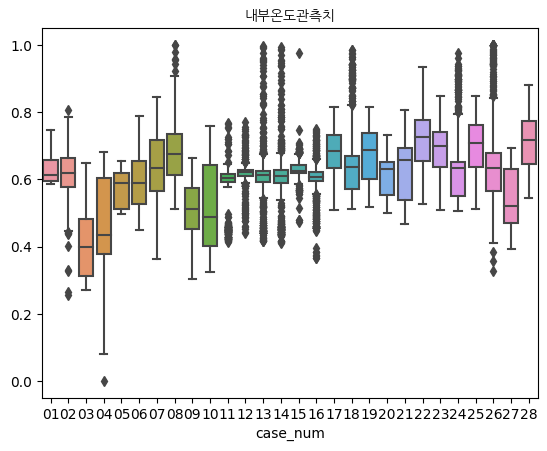

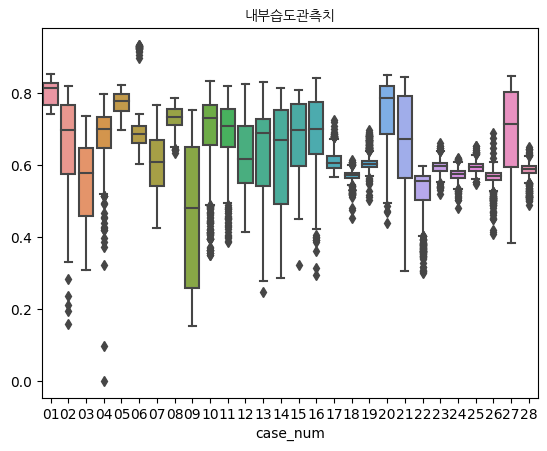

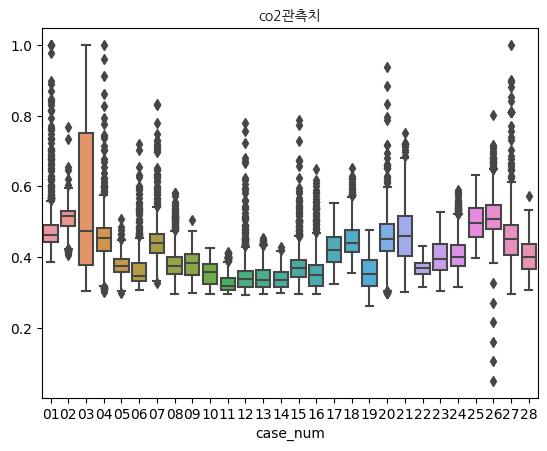

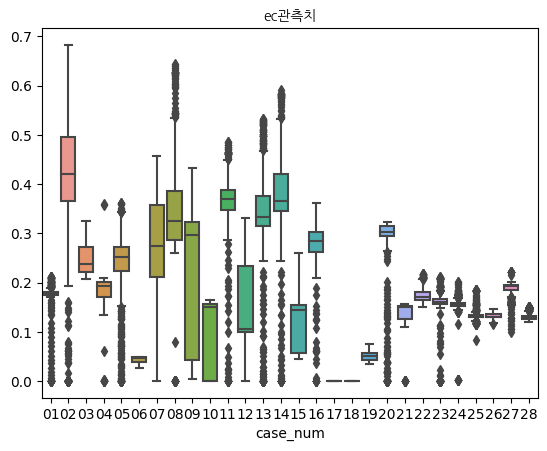

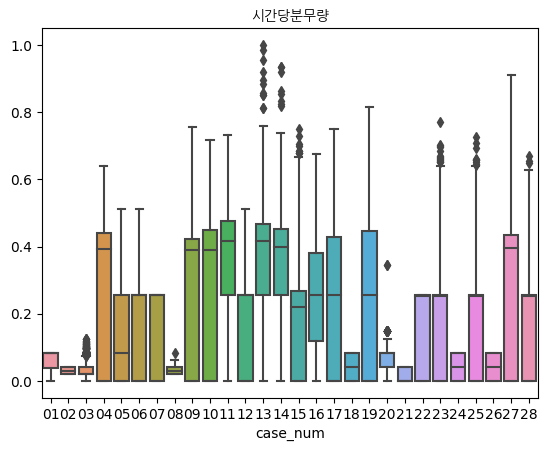

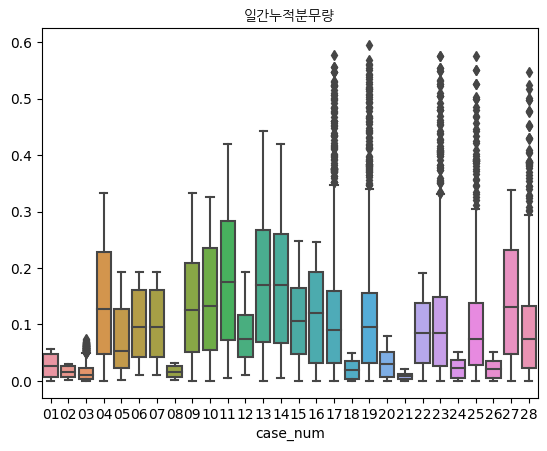

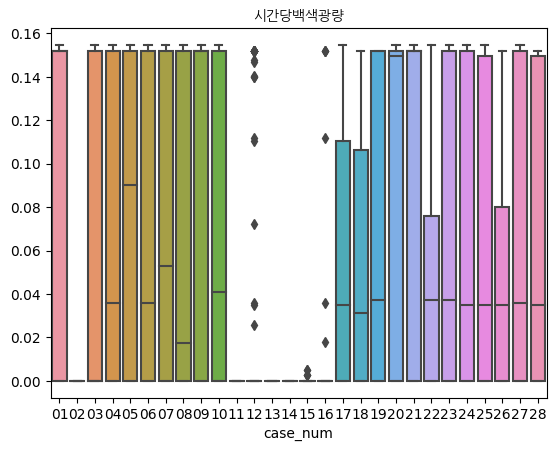

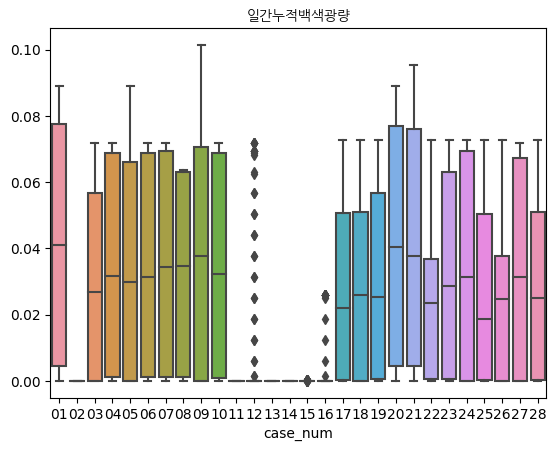

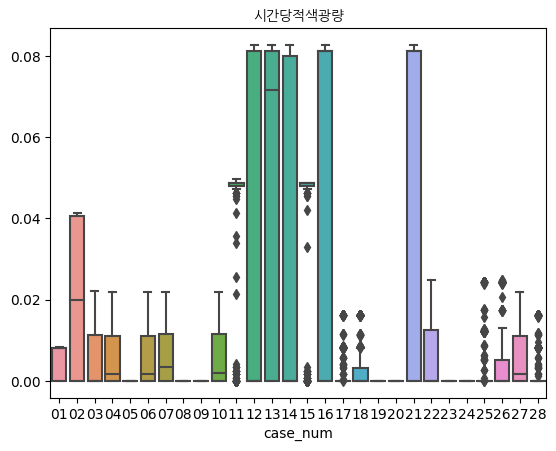

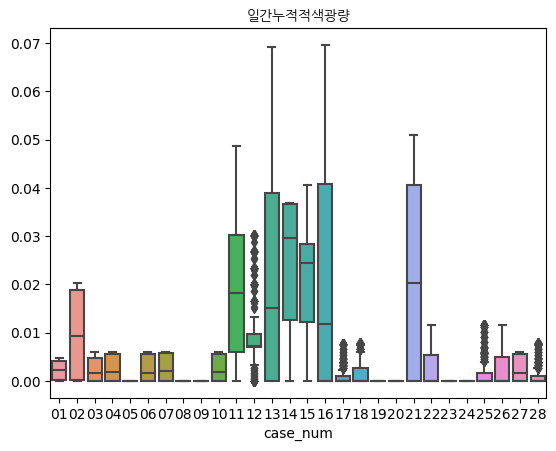

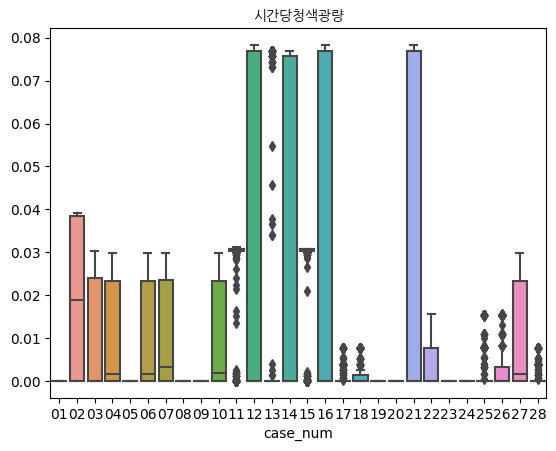

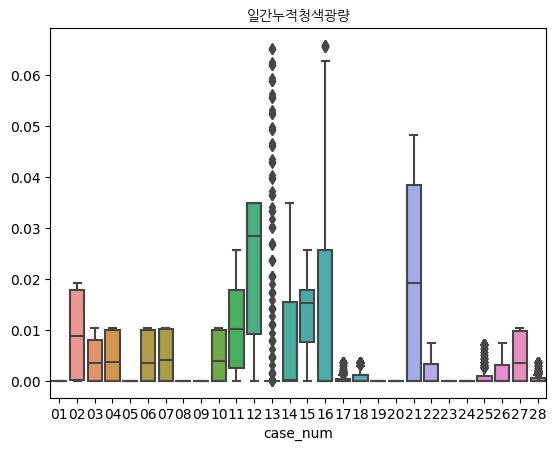

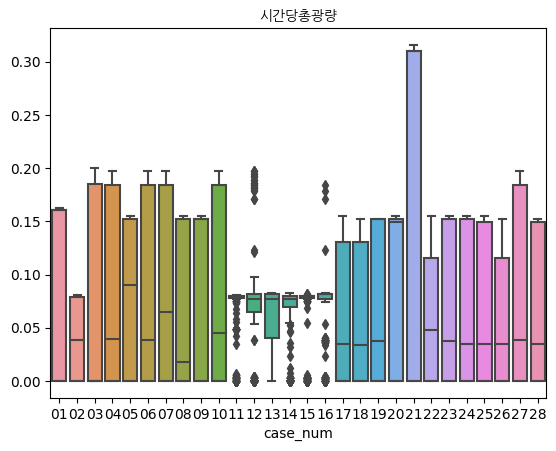

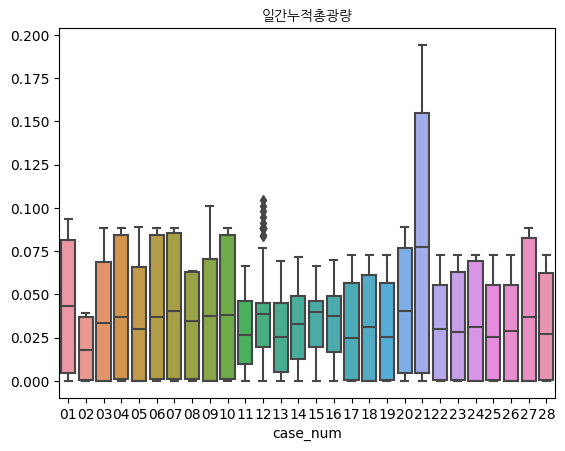

In [291]:
input_df.head()

for col in input_df.drop(columns=['DAT','obs_time','case_num']).columns:
    plt.figure()
    sns.boxplot(x=input_df.case_num,y=input_df[col])
    plt.ylabel('')
    plt.title(col,fontproperties=fp)
    plt.show()

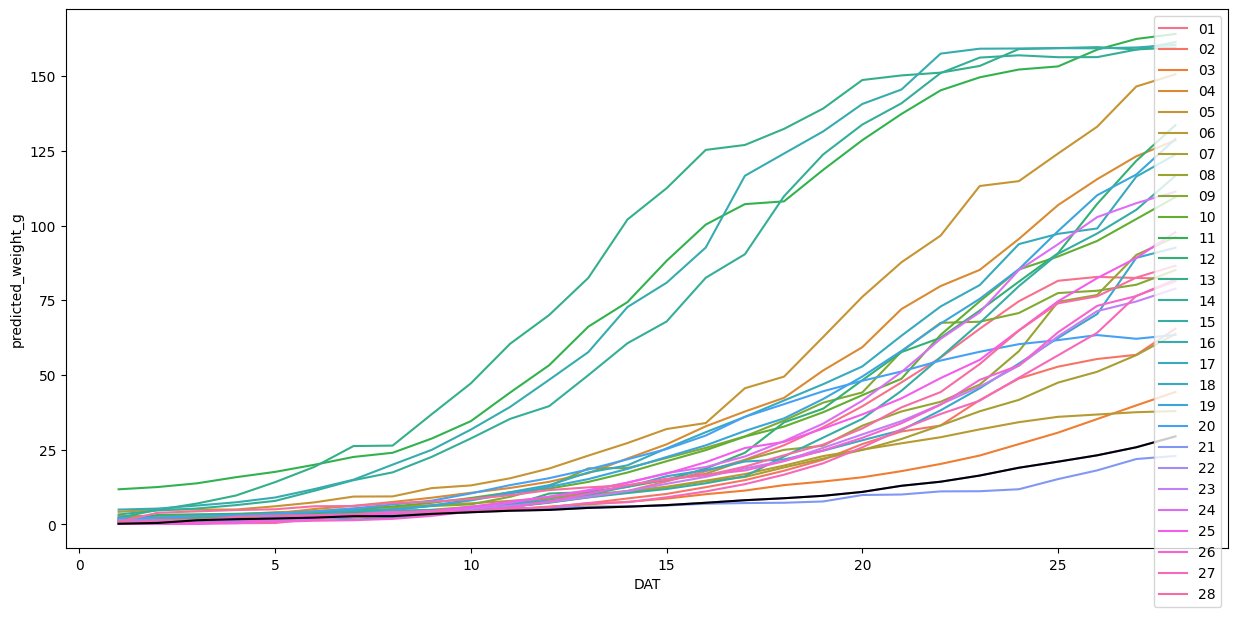

In [289]:
label_df.head()

d=label_df[label_df.case_num=='22']

plt.figure(figsize=(15,7))
sns.lineplot(x=label_df.DAT,y=label_df.predicted_weight_g,hue=label_df.case_num)
sns.lineplot(x=d.DAT,y=d.predicted_weight_g,color='black')
plt.show()

In [277]:
train_dataset = CustomDataset(input=X_train, label=y_train, infer_mode=False)
train_loader  = DataLoader(train_dataset, batch_size = 8, shuffle=False, num_workers=6) # CFG['BATCH_SIZE']

valid_dataset = CustomDataset(input=X_valid, label=y_valid, infer_mode=False)
valid_loader  = DataLoader(valid_dataset, batch_size = 8, shuffle=False, num_workers=6) # CFG['BATCH_SIZE']

In [278]:
input_size = [np.array(x[0]).shape for x in train_loader][0][2]
model = BaseModel(
    input_size = input_size,
    hidden_sizes=[32,16],
    dropout_rates=[0.2,0.2],
    num_classes=1,
    num_layers=1,
    bidirectional=False,
)
# model = GRUModel(input_dim=X_train.shape[1], hidden_dim=64, layer_dim=1, output_dim=1)

lr = 0.001 #0.00001

model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr, weight_decay=1e-5)
# optimizer = torch.optim.SGD(params = model.parameters(), lr = lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs',min_lr=1e-8, verbose=False)

best_model = train(
    model,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
    scheduler=scheduler,
    device=device,
    early_stopping=False,
    metric_period=1,
    epochs=2048,
)

[0001/2048] tr_loss : 39.07882, val_loss : 26.26583, elapsed : 4.66s, total : 4.66s, remaining : 9542.37s
[0002/2048] tr_loss : 37.50421, val_loss : 24.47244, elapsed : 4.04s, total : 8.70s, remaining : 8260.42s
[0003/2048] tr_loss : 35.41186, val_loss : 23.16883, elapsed : 3.86s, total : 12.56s, remaining : 7892.62s
[0004/2048] tr_loss : 34.00598, val_loss : 23.29395, elapsed : 3.51s, total : 16.08s, remaining : 7178.92s
[0005/2048] tr_loss : 33.36095, val_loss : 22.84578, elapsed : 3.52s, total : 19.60s, remaining : 7196.48s
[0006/2048] tr_loss : 31.75125, val_loss : 20.54872, elapsed : 3.74s, total : 23.34s, remaining : 7641.24s
[0007/2048] tr_loss : 29.78499, val_loss : 20.16409, elapsed : 4.06s, total : 27.40s, remaining : 8289.51s
[0008/2048] tr_loss : 28.27358, val_loss : 20.38485, elapsed : 4.03s, total : 31.43s, remaining : 8221.03s
[0009/2048] tr_loss : 27.43377, val_loss : 20.67795, elapsed : 3.66s, total : 35.10s, remaining : 7467.43s
[0010/2048] tr_loss : 27.12500, val_los

KeyboardInterrupt: 

In [143]:
# [np.array(x[0]).shape for x in train_loader]

In [ ]:
iter = 0
for x,y in train_loader:
    iter+=1
    if iter==1:
        tmp = x

tmp.shape

torch.Size([8, 24, 16])

In [196]:
latent_dim = 3
x = tmp; print(x.shape)

enc1 = nn.Linear(16, 64)
enc2 = nn.Linear(64, 64)
latent = nn.Linear(64, latent_dim*2)

z = F.elu(enc1(x)); print(z.shape)
z = F.elu(enc2(z)); print(z.shape)
z = latent(z)     ; print(z.shape)
mu = z[:, 0:latent_dim,:]

z[:,latent_dim:,:].shape

torch.Size([8, 24, 16])
torch.Size([8, 24, 64])
torch.Size([8, 24, 64])
torch.Size([8, 24, 6])


torch.Size([8, 21, 6])

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SciNet(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, layer_dim):
        """Initialize SciNet Model.

        Params
        ======
            input_dim (int): number of inputs
            output_dim (int): number of outputs
            latent_dim (int): number of latent neurons
            Layer_dim (int): number of neurons in hidden layers
        """
        super(SciNet, self).__init__()
        self.latent_dim = latent_dim
        self.enc1 = nn.Linear(input_dim, layer_dim)
        self.enc2 = nn.Linear(layer_dim, layer_dim)
        self.latent = nn.Linear(layer_dim, latent_dim*2)
        self.dec1 = nn.Linear(latent_dim+1, layer_dim)
        self.dec2 = nn.Linear(layer_dim,layer_dim)
        self.out = nn.Linear(layer_dim, output_dim)

    def encoder(self, x):
        z = F.elu(self.enc1(x))
        z = F.elu(self.enc2(z))
        z = self.latent(z)
        self.mu = z[:, 0:self.latent_dim,:]
        self.log_sigma = z[:,self.latent_dim:,:]
        print(self.mu.shape, self.log_sigma.shape)
        self.sigma = torch.exp(self.log_sigma)

        # Use reparametrization trick to sample from gaussian
        eps = torch.randn(x.size(0), self.latent_dim, self.latent_dim*2)
        print(self.mu.shape, self.sigma.shape, eps.shape)
        z_sample = self.mu + self.sigma * eps

        # Compute KL loss
        self.kl_loss = kl_divergence(self.mu, self.log_sigma, dim=self.latent_dim)

        return z_sample

    def decoder(self, z):
        x = F.elu(self.dec1(z))
        x = F.elu(self.dec2(x))
        return self.out(x)

    def forward(self, obs):
        q = obs[:,-1:,:]
        obs = obs[:,0:-1,:]
        self.latent_r = self.encoder(obs) 
        dec_input = torch.cat( (q, self.latent_r), 1)

        return self.decoder(dec_input)


def kl_divergence(means, log_sigma, dim, target_sigma=0.1):
    """
    Computes Kullback–Leibler divergence for arrays of mean and log(sigma)
    """
    target_sigma = torch.Tensor([target_sigma])
    return 1 / 2. * torch.mean(torch.mean(1 / target_sigma**2 * means**2 +
            torch.exp(2 * log_sigma) / target_sigma**2 - 2 * log_sigma + 2 * torch.log(target_sigma), dim=1) - dim)

In [193]:
import numpy as np
import torch

def pendulum(t, A0, delta0, k, b, m):
	"""
	Solution x(t) for pendulum differential equation
		mx'' = -kx + bx'
	Returns position at time t
	Parameters:
		- t: time
		- A0: starting amplitude
		- delta0: phase
		- k: spring constant
		- b: damping factor
	"""
	A = 1 - b**2 / (4 * m * k)
	if A < 0:
		return None
	w = np.sqrt(k/m)* np.sqrt(A)
	result = A0 * np.exp( - t * b / (2. * m) ) * np.cos(w * t + delta0)
	return result

def target_loss(pred,answer):
	"""
	
	"""
	pred = pred[:,0]
	
	return torch.mean(torch.sum((pred - answer)**2), dim=0)

In [194]:
scinet = SciNet(input_dim=X_train.shape[1], output_dim=1, latent_dim=3, layer_dim=64)
scinet

N_EPOCHS = 100
optimizer = optim.Adam(scinet.parameters())
hist_error = []
hist_loss = []
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(train_loader):

        inputs, outputs = minibatch
        optimizer.zero_grad()
        pred = scinet.forward(inputs)
        
        loss = target_loss(pred, outputs) + beta * scinet.kl_loss
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_loss.append(loss.data.detach().numpy())
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    print("Epoch %d -- loss %f, RMS error %f " % (epoch+1, hist_loss[-1], hist_error[-1]))

torch.Size([8, 3, 6]) torch.Size([8, 20, 6])
torch.Size([8, 3, 6]) torch.Size([8, 20, 6]) torch.Size([8, 3, 6])


RuntimeError: The size of tensor a (20) must match the size of tensor b (3) at non-singleton dimension 1

In [ ]:
# # input_size = [np.array(x[0]).shape for x in train_loader][0][2]
# model = BaseModel(
#     input_size = X_train.shape[1],
#     hidden_sizes=[32,16],
#     dropout_rates=[0.2,0.2],
#     num_classes=1,
#     num_layers=1,
#     bidirectional=False,
# )
# # model = GRUModel(input_dim=X_train.shape[1], hidden_dim=64, layer_dim=1, output_dim=1)

# model.eval()
# optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-6)# lr = CFG["LEARNING_RATE"], weight_decay=1e-5)
# # optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-4, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs',min_lr=1e-8, verbose=False)

# best_model = train(
#     model,
#     optimizer=optimizer,
#     train_loader=train_loader,
#     valid_loader=valid_loader,
#     scheduler=scheduler,
#     device=device,
#     early_stopping=False,
#     metric_period=1,
#     epochs=1024,
# )

# test_df = test_df[X_train.columns]
# test_dataset = CustomTestDataset(input=test_df)
# test_loader  = DataLoader(test_dataset, shuffle=False, num_workers=0)

# model.to(device)
# model.eval()
# test_pred = []
# with torch.no_grad():
#     for X in iter(test_loader):
#         X = X.float().to(device)

#         model_pred = model(X)
#         # model_pred = torch.exp(model_pred)
#         model_pred = model_pred.cpu().numpy().reshape(-1).tolist()

#         test_pred += model_pred

In [ ]:
for name, param in model.named_parameters():
    print(name, param.grad.abs().sum())

In [ ]:
test_df['predicted_weight_g'] = test_pred
test_df.head()

<br></br>
GRU

In [ ]:
import math

class GRUCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size,  3*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3*hidden_size, bias=bias)
        self.reset_parameters()
        
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() : 
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden) : 
        x = x.view(-1, x.size(1))
        
        gate_x = self.x2h(x)
        gate_h = self.h2h(hidden)
        
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)
        
        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + (resetgate * h_n))
        
        hy = newgate + inputgate * (hidden - newgate)
        return hy
    
class GRUModel(nn.Module) :
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x) :
        if torch.cuda.is_available() :
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else :
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        outs = []
        hn = h0[0, :, :]
        
        for seq in range(x.size(1)) : 
            hn = self.gru_cell(x[:, seq, :], hn)
            outs.append(hn)
        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

<br></br>

# Inference

In [ ]:
test_input_list = sorted(glob.glob('./out/test_input/*.csv'))
test_target_list = sorted(glob.glob('./data/test_target/*.csv'))

In [ ]:
def inference_per_case(model, test_loader, test_path, device):
    model.to(device)
    model.eval()
    pred_list = []
    with torch.no_grad():
        for X in iter(test_loader):
            X = X.float().to(device)
            
            model_pred = model(X)
            model_pred = torch.exp(model_pred)
            model_pred = model_pred.cpu().numpy().reshape(-1).tolist()

            pred_list += model_pred
    
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = pred_list
    submit_df.to_csv(test_path, index=False)

In [ ]:
for test_input_path, test_target_path in zip(test_input_list, test_target_list):
    test_dataset = CustomDataset([test_input_path], [test_target_path], True)
    test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    inference_per_case(best_model, test_loader, test_target_path, device)

In [ ]:
import zipfile
os.chdir("./data/test_target/")
submission = zipfile.ZipFile("../submission.zip", 'w')
for path in test_target_list:
    path = path.split('/')[-1]
    submission.write(path)
submission.close()